# Unsupervised Learning Project 6 - Customer Segmentation
## Paige Singleton
## October 2022
## Problem Statement
### "Identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers."

### Data Dictionary
- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Questions to be answered
1) How can we improve market penetration?
2) How should we personalize our marketing campaigns to new customers? to existing customers?
3) What steps should we take to upgrade the service delivery models, to "ensure that customer queries are resolved faster?'


In [1]:
# From MLS Engineering College Great Learning Jupyter notebook file
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the dataset
data = pd.read_csv("Credit Card Customer Data.csv")

In [3]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
data.duplicated().sum()

0

In [6]:
data.shape

(660, 7)

## Exploratory Data Analysis
Data background and contents - Univariate analysis - Bivariate analysis - Insights based on EDA

See above for Data Background and contents, problem statement and questions to be answered


### Univariate Analysis

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [8]:
data.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [9]:
# function to create labeled barplots (code from Great Learning Resource - MLS - Engineering colleges Case Study)


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [10]:
list(data.columns)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

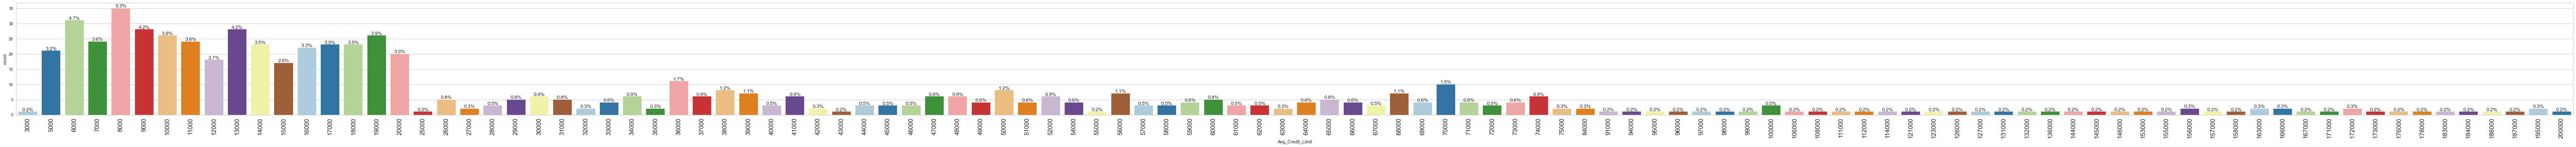

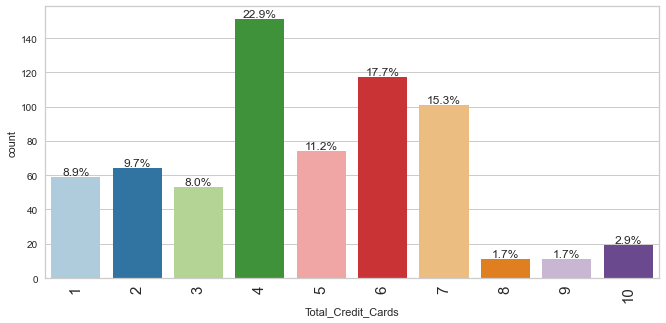

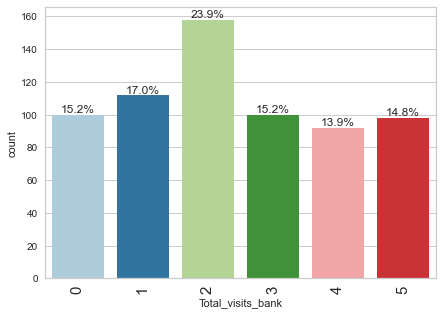

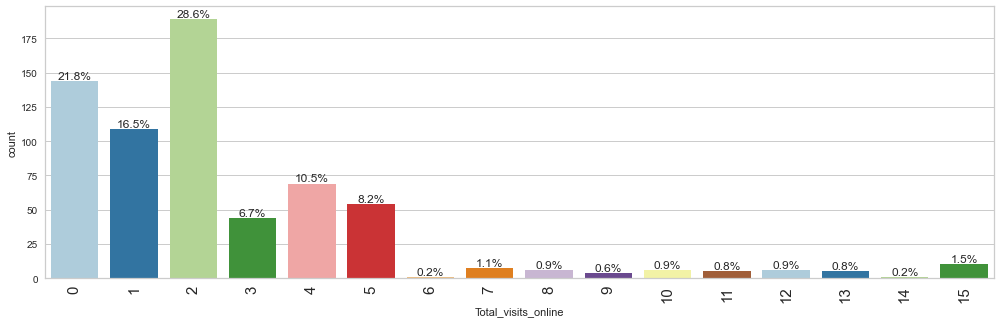

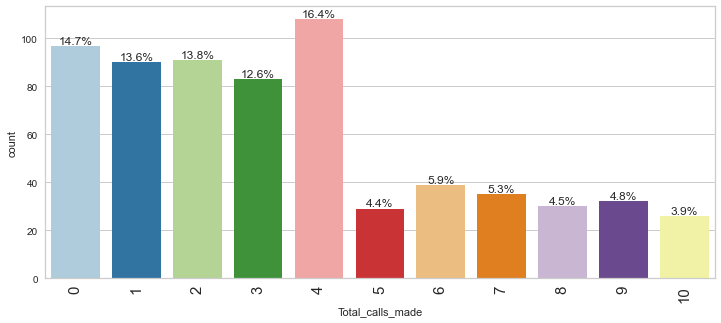

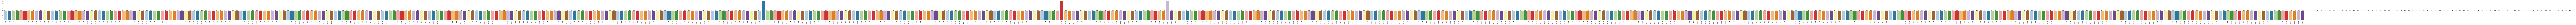

In [11]:
# Designate informative columns, all numberical','
info_col = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made', 'Customer Key']
for col in info_col:
    labeled_barplot(data, col, perc=True)

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Count'>

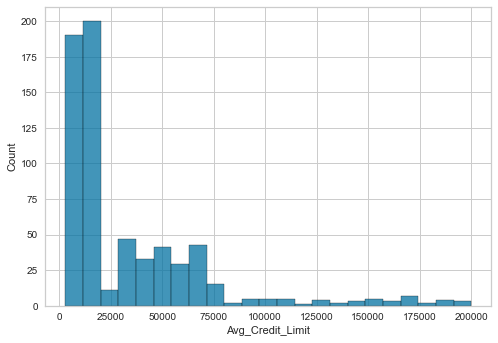

In [12]:
#Data Distribution of Average Credit limit
sns.histplot(data=data, x='Avg_Credit_Limit')

In [13]:
# From Anime Rating Prediction case study, function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

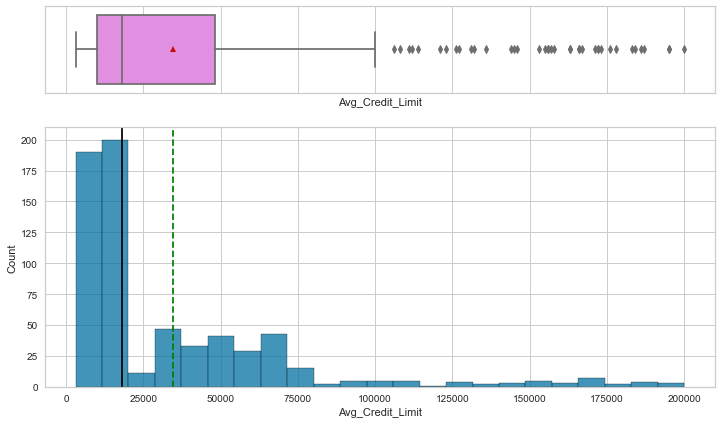

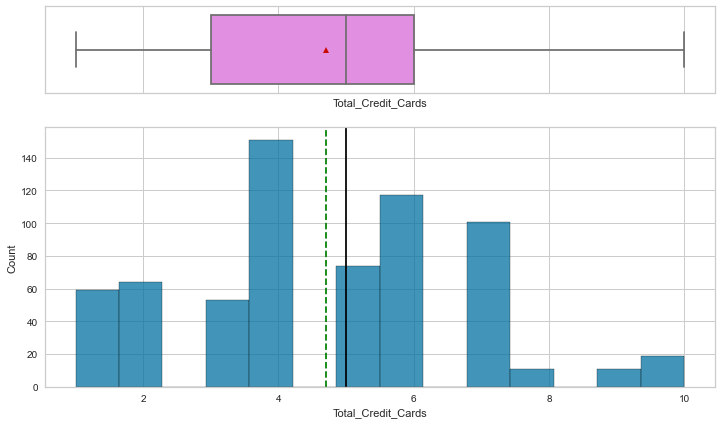

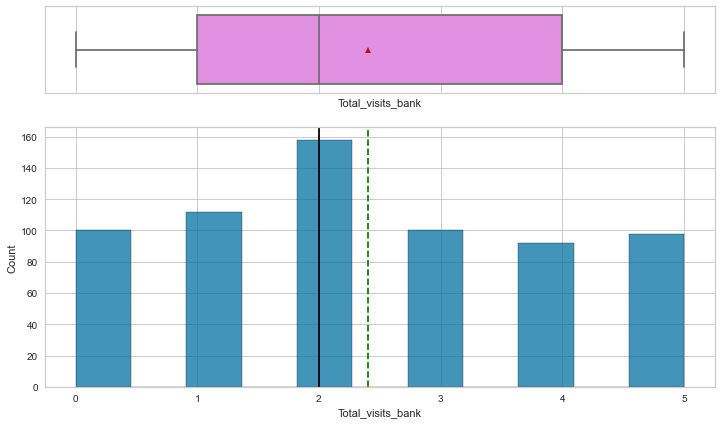

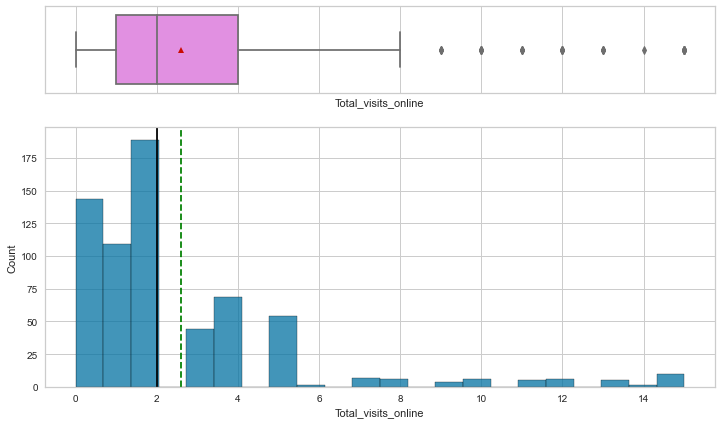

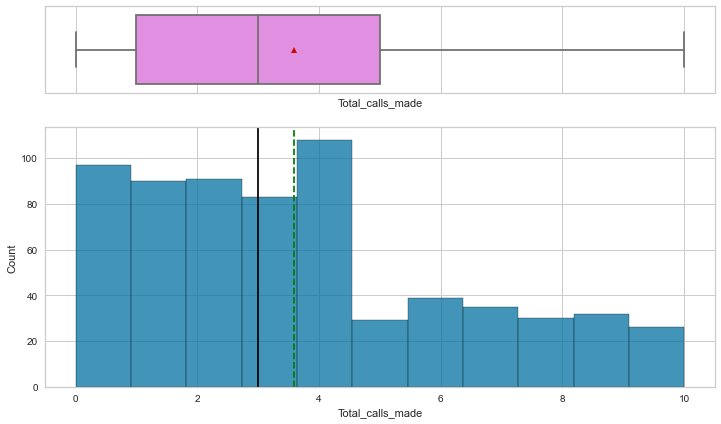

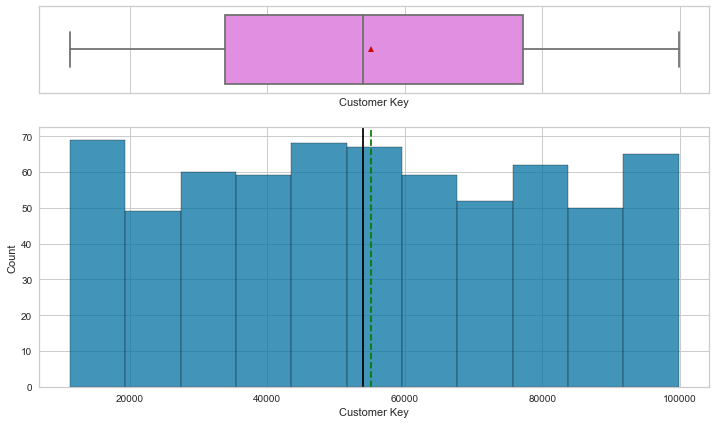

In [14]:
for col in info_col:
    histogram_boxplot(data, col)

### Bivariate Analysis


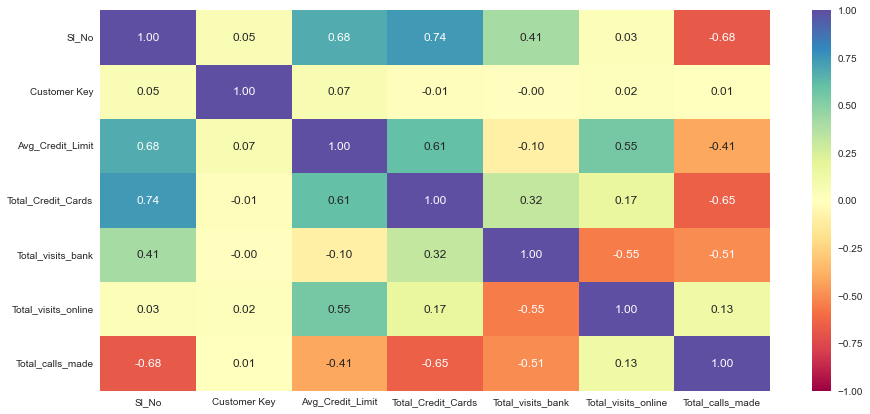

In [15]:
# Corrlation Matrix (using code from MLS - Engineering colleges case study)
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

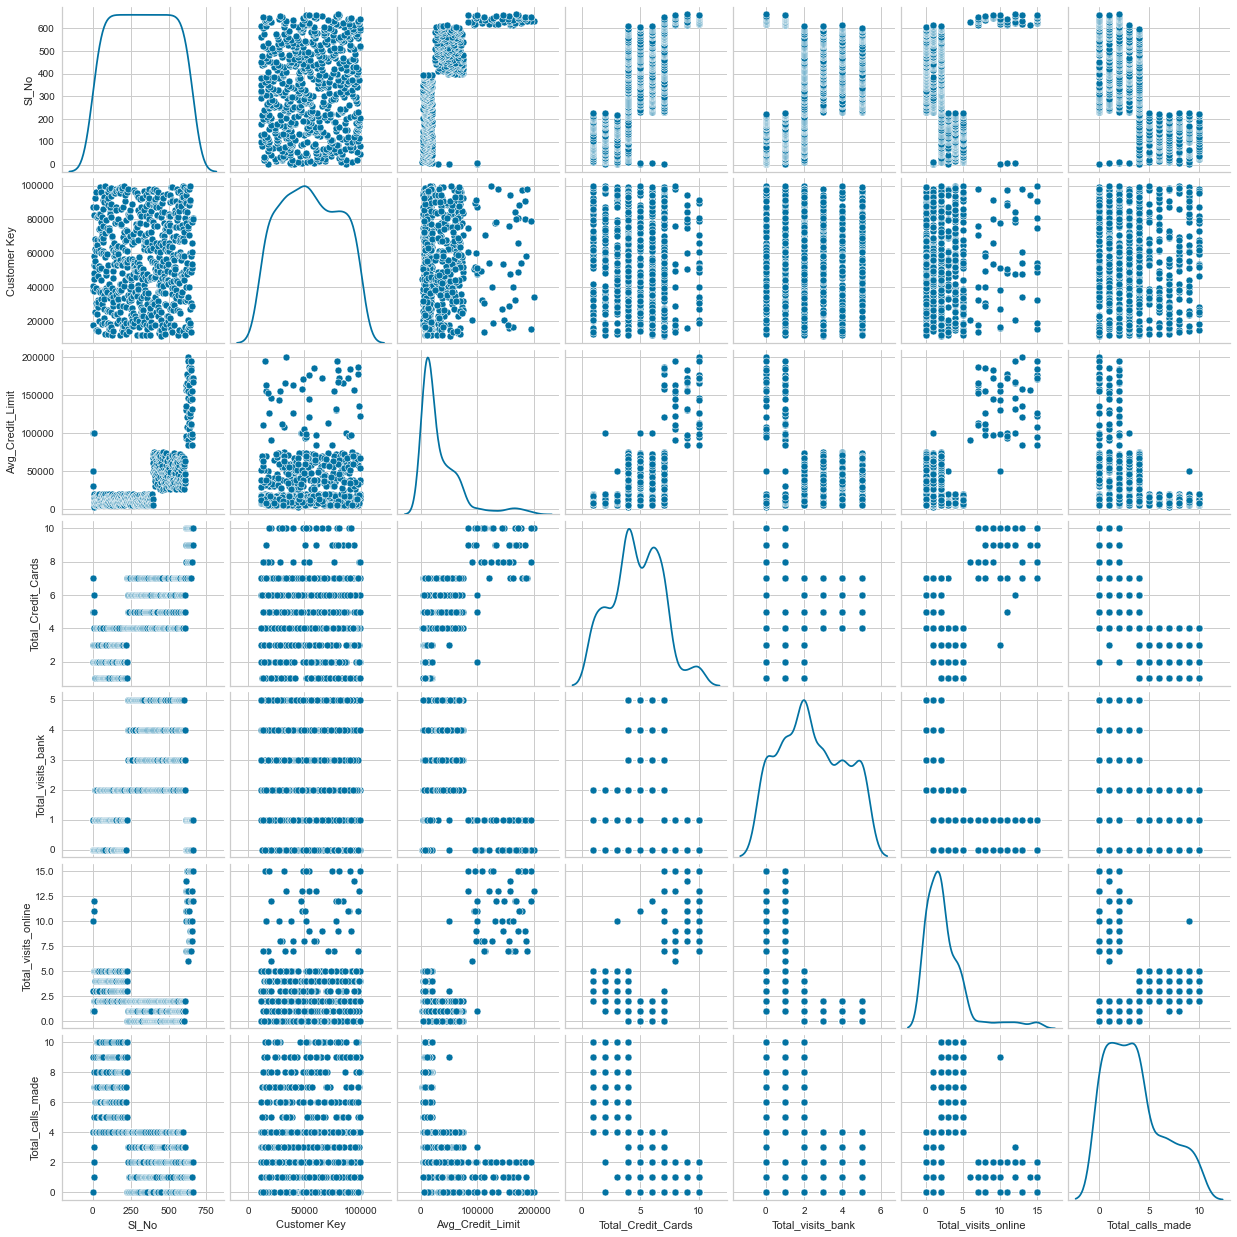

In [16]:
sns.pairplot(data , diag_kind = 'kde',diag_kws=dict(fill=False))
plt.show()

### EDA Insights

##### Sanity Check 
- the data set has 660 rows and 7 columns
- SL_No is seriel and therefore non - informative; should be dropped from the dataset
- there are not duplicates (for the entire set)
- there are no nulls in the data set

##### EDA Insights 
- Sl_No: Primary key of the records - non informative; should be dropped
- Customer Key: Customer identification number
    - does not appear to be seriel
    - mean and mean are similar
    - might be some duplicates 
    - explore duplicates
    - higher customer keys appear to be associated with higher credit limits and total visitis online
    - Question: are customer numbers assigned based on other criteria and therefore informative?
    - From the FAQ's: "The 'Customer Key' is a unique ID given to each customer in the database. The duplicate values might correspond to customer profile changes, and as such, there is no need to delete these records as these are actual occurrences at some point in the time. The column can be dropped during the analysis." therefore, frop this column.
- Average Credit Limit: Average credit limit of each customer for all credit cards
    - disparity between mean and median therefore data is skewed right
    - outliers on the high end of the data
    - is correlated to other variables: Total credit cards (.61); Total visits online (0.55); and Total calls made (-.41) therefore consider the impact of multi-collinearity   
- Total credit cards: Total number of credit cards possessed by the customer
    - values are integer values from 1 to 10, inclusive
    - is correlated to other variables: Verage Credit Limit (.61); Total visits bank (0.32); and Total calls made (-.65) therefore consider the impact of multi-collinearity
    - distribution is not skewed
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
    - values Range from 0 to 5, inclusive
    - Mode is 2; otherewise the data is faily uniform
    - appear to be no outliers
    - is correlated to other variables: Total credit cards (.32); Total visits online (-0.55); and Total calls made (-.51) therefore consider the impact of multi-collinearity 
- Total visits online: Total number of visits or online logins made by the customer (yearly)
    - Range from 0 to 15, inclusive, with median of 2
    - Outliers are present (high end)
    - data is skewed right
    - is correlated to other variables: Total visits bank (-0.55); and Average credit limit (0.55) therefore consider the impact of multi-collinearity 
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)
    - Range from 0 to 10, inclusive, with median of 3
    - data is slightly skewed
    - no outliers
    - is correlated to other variables: Total credit cards (-.65); Total visits bank (-0.51); and Average Credit Limit(-.41) therefore consider the impact of multi-collinearity 

In [17]:
#Before pre-processing, make a copy of the dataset
data2 = data.copy()


## Data Preprocessing
Prepare the data for analysis - Feature engineering - Missing value treatment - Outlier treatment - Duplicate observations check

In [18]:
# dropping the serial no. and customer Key  columns as it does not provide any information
data.drop(["Sl_No","Customer Key"], axis=1, inplace=True)

### Feature Analysis

### Missing Value Treatment

In [19]:
# checking for missing values
data.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

##### There are no missing values therefore missing value treatment is not appicable

### Outlier Treatment (Using code from Great Learning resources on Outlier treatment)

#### Average Credit Limit

In [20]:
#Per EDA, check for outliers on "Avrage Credit limit" feature 
quartiles = np.quantile(data['Avg_Credit_Limit'][data['Avg_Credit_Limit'].notnull()], [.25, .75])
ACL_power_4iqr = 4 * (quartiles[1] - quartiles[0])
print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, ACL_4*IQR = {ACL_power_4iqr}')
outlier_powers = data.loc[np.abs(data['Avg_Credit_Limit'] - data['Avg_Credit_Limit'].median()) > ACL_power_4iqr, 'Avg_Credit_Limit']
outlier_powers

Q1 = 10000.0, Q3 = 48000.0, ACL_4*IQR = 152000.0


622    176000
624    178000
630    200000
631    195000
632    187000
637    173000
639    184000
645    171000
646    186000
647    183000
650    195000
654    172000
658    172000
Name: Avg_Credit_Limit, dtype: int64

In [21]:
#Per EDA, check for outliers on "Total_visits_online" feature 
quartiles = np.quantile(data['Total_visits_online'][data['Total_visits_online'].notnull()], [.25, .75])
TVO_power_4iqr = 4 * (quartiles[1] - quartiles[0])
print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, TVO_power_4iqr = {TVO_power_4iqr}')
outlier_powers = data.loc[np.abs(data['Total_visits_online'] - data['Total_visits_online'].median()) > TVO_power_4iqr, 'Total_visits_online']
outlier_powers 

Q1 = 1.0, Q3 = 4.0, TVO_power_4iqr = 12.0


620    15
622    15
628    15
631    15
639    15
640    15
644    15
645    15
653    15
658    15
Name: Total_visits_online, dtype: int64

In [22]:
data_RO = pd.DataFrame(data, columns = data.columns)

In [23]:
data_RO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [24]:
#Create a dataset with outliers replaced with Q3 (feature:Average Credit Limit)
#Replace the outliers with  Q3 for outliers above the median
data_RO['Avg_Credit_Limit'].mask(data_RO['Avg_Credit_Limit'] > ACL_power_4iqr, data_RO['Avg_Credit_Limit'].quantile(.75), inplace=True)

In [25]:
#Replace the outliers with  Q3 for outliers above the median for data_RO.Total_visits_online
data_RO['Total_visits_online'].mask(data_RO['Total_visits_online'] > TVO_power_4iqr, data_RO['Total_visits_online'].quantile(.75), inplace=True)

### Duplicate Observation Check

In [26]:
#Check for duplicates again after removing the Seriel number and customer key columns

data.duplicated().sum()

13

In [27]:
#Remove duplicates (per code in Product segmentation notebook)
data = data[(~data.duplicated())].copy()

In [28]:
data_RO.duplicated().sum()

13

In [29]:
#Remove duplicates (per code in Product segmentation notebook)
data_RO = data_RO[(~data_RO.duplicated())].copy()

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     647 non-null    int64
 1   Total_Credit_Cards   647 non-null    int64
 2   Total_visits_bank    647 non-null    int64
 3   Total_visits_online  647 non-null    int64
 4   Total_calls_made     647 non-null    int64
dtypes: int64(5)
memory usage: 30.3 KB


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     647 non-null    int64
 1   Total_Credit_Cards   647 non-null    int64
 2   Total_visits_bank    647 non-null    int64
 3   Total_visits_online  647 non-null    int64
 4   Total_calls_made     647 non-null    int64
dtypes: int64(5)
memory usage: 30.3 KB


### Feature Scaling (per code in Product segmentation workbook)

In [32]:
num_col = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
# scaling the dataset before clustering for data
scaler = StandardScaler()
data_subset = data[num_col].copy()
data_subset_scaled = scaler.fit_transform(data_subset)

In [33]:
# scaling the dataset before clustering for data_RO
scaler = StandardScaler()
data_RO_subset = data[num_col].copy()
data_RO_subset_scaled = scaler.fit_transform(data_RO_subset)

In [34]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     647 non-null    int64
 1   Total_Credit_Cards   647 non-null    int64
 2   Total_visits_bank    647 non-null    int64
 3   Total_visits_online  647 non-null    int64
 4   Total_calls_made     647 non-null    int64
dtypes: int64(5)
memory usage: 30.3 KB


## Applying K-means Clustering (Using scripts from Session notebook, Engineering colleges study)
Apply K-means Clustering - Plot the Elbow curve - Check Silhouette Scores - Figure out appropriate number of clusters - Cluster Profiling

### Apply K-Means Clustering (for data set without removing outliers)

In [35]:
#Outliers are few therefore applying Euclidean distance
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(data_subset_scaled)  # Fit kMeans on the data
    prediction = model.predict(data_subset_scaled)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(data_subset_scaled, model.cluster_centers_, "euclidean"), axis=1))
        / data_subset_scaled.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

Number of Clusters: 1 	Average Distortion: 2.068780806040957
Number of Clusters: 2 	Average Distortion: 1.4875324579482212
Number of Clusters: 3 	Average Distortion: 1.2839591466444151
Number of Clusters: 4 	Average Distortion: 1.1617190769330086
Number of Clusters: 5 	Average Distortion: 1.0954007213656722
Number of Clusters: 6 	Average Distortion: 1.0426144232323509
Number of Clusters: 7 	Average Distortion: 1.0097099943957633
Number of Clusters: 8 	Average Distortion: 0.9716758477361024


### Plot Elbow Curve

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

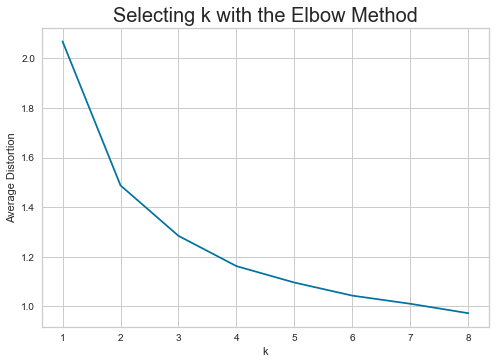

In [36]:
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)

##### Determine approrpiate values of k
In the elbow plot, "elbows" appear at k=2 (most prominent) and possible k =3 and k=4 (Less prominent)
Check silhouette scores for K=2,3,4

### Check Sihouette Scores

For n_clusters = 2, silhouette score is 0.42034311064705965
For n_clusters = 3, silhouette score is 0.4847131450514744
For n_clusters = 4, silhouette score is 0.3593706124279728
For n_clusters = 5, silhouette score is 0.32664372228316335
For n_clusters = 6, silhouette score is 0.2432038344362063
For n_clusters = 7, silhouette score is 0.24152236865119708
For n_clusters = 8, silhouette score is 0.23570822975705694
For n_clusters = 9, silhouette score is 0.2245468209966364


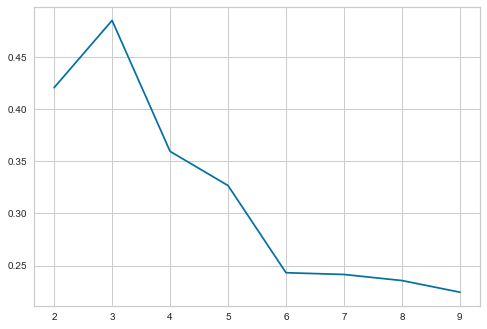

In [37]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((data_subset_scaled))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_subset_scaled, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

##### Determining k value
K=2,3 appear to be k apprpriate k values for further investigation

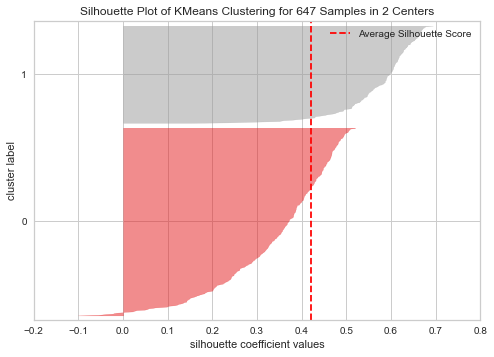

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 647 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
# finding optimal no. of clusters with silhouette coefficients: k = 2
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(data_subset_scaled)
visualizer.show()

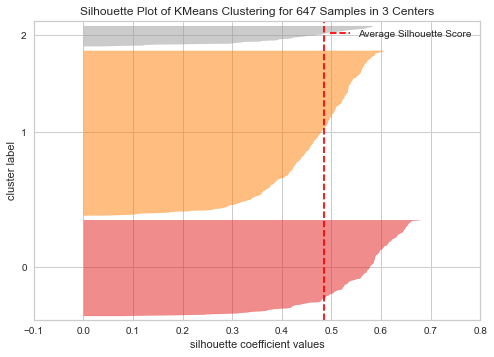

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 647 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
# finding optimal no. of clusters with silhouette coefficients: k = 3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_subset_scaled)
visualizer.show()

### Determine Number of clusters

##### Observations
From the above plot, we can see that all the clusters have crossed Avg silhouette score, all the clusters have different silhouette scores and have different width sizes, there is an elbow at K=2 and k =3. The silhouette score for k=3 is higher meaning that the clusters are farther away from each other, therefore I will choose k=3.

### Cluster Profile

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_subset_scaled)

KMeans(n_clusters=3, random_state=0)

In [41]:
# adding kmeans cluster labels to the original dataframe
data["K_means_segments"] = kmeans.labels_

In [75]:
data_cluster_profile = data.groupby("K_means_segments").median()

In [76]:
data_cluster_profile["count_in_each_segment"] = (
    data.groupby("K_means_segments")["Total_calls_made"].count().values
)

In [77]:
data_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters_3,HC_Clusters_4,count_in_each_segment
K_means_segments,,,,,,,,
0,91000.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,47
1,32000.000000,6.000000,3.000000,1.000000,2.000000,0.000000,0.000000,379
2,12000.000000,2.000000,1.000000,4.000000,7.000000,0.000000,0.000000,221


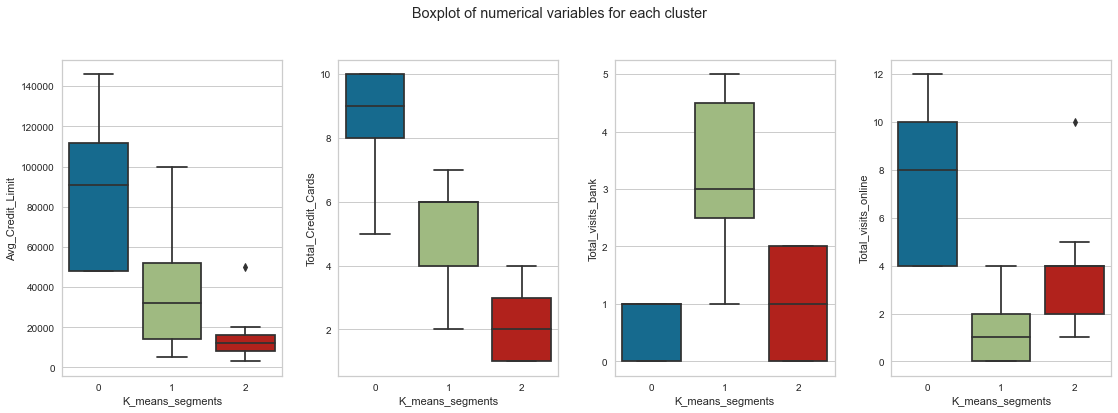

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=data[num_col[counter]], x=data["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Applying Hierarchical Clustering (using code from Session notebook - Clustering Counties)
Apply Hierarchical clustering with different linkage methods - Plot dendrograms for each linkage method - Check cophenetic correlation for each linkage method - Figure out appropriate number of clusters - Cluster Profiling

In [46]:
!pip install tensorflow==2.9.1

In [47]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [72]:
#Shape of data_subset_scaled
data_subset_scaled.shape



(647, 5)

### Check cophenetic correlation for each linkage method

In [48]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_subset_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_subset_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.6060113482302135.
Cophenetic correlation for Euclidean distance and complete linkage is 0.836986184690063.
Cophenetic correlation for Euclidean distance and average linkage is 0.8452415372722547.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8387649441633593.
Cophenetic correlation for Chebyshev distance and single linkage is 0.5622444707469257.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7678100075896981.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8571503585449765.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8572035550315541.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.5808907739369856.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5831297956120748.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7738233561240467.
Cophenetic cor

In [49]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8572035550315541, which is obtained with Chebyshev distance and weighted linkage.


In [50]:
# Explore additional linkage for Euclidean distance
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(data_subset_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(data_subset_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm


Cophenetic correlation for single linkage is 0.6060113482302135.
Cophenetic correlation for complete linkage is 0.836986184690063.
Cophenetic correlation for average linkage is 0.8452415372722547.
Cophenetic correlation for centroid linkage is 0.8384568146790712.
Cophenetic correlation for ward linkage is 0.7234319886726732.
Cophenetic correlation for weighted linkage is 0.8387649441633593.


In [51]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8452415372722547, which is obtained with average linkage.


##### Highest cophenetic correlation
The highest correlataion appears to be approximately 0.8572035550315541, which is obtained with Chebyshev distance and weighted linkage.

### Apply Hierarchical clustering with different linkage methods

### Plot dendrograms for each linkage method

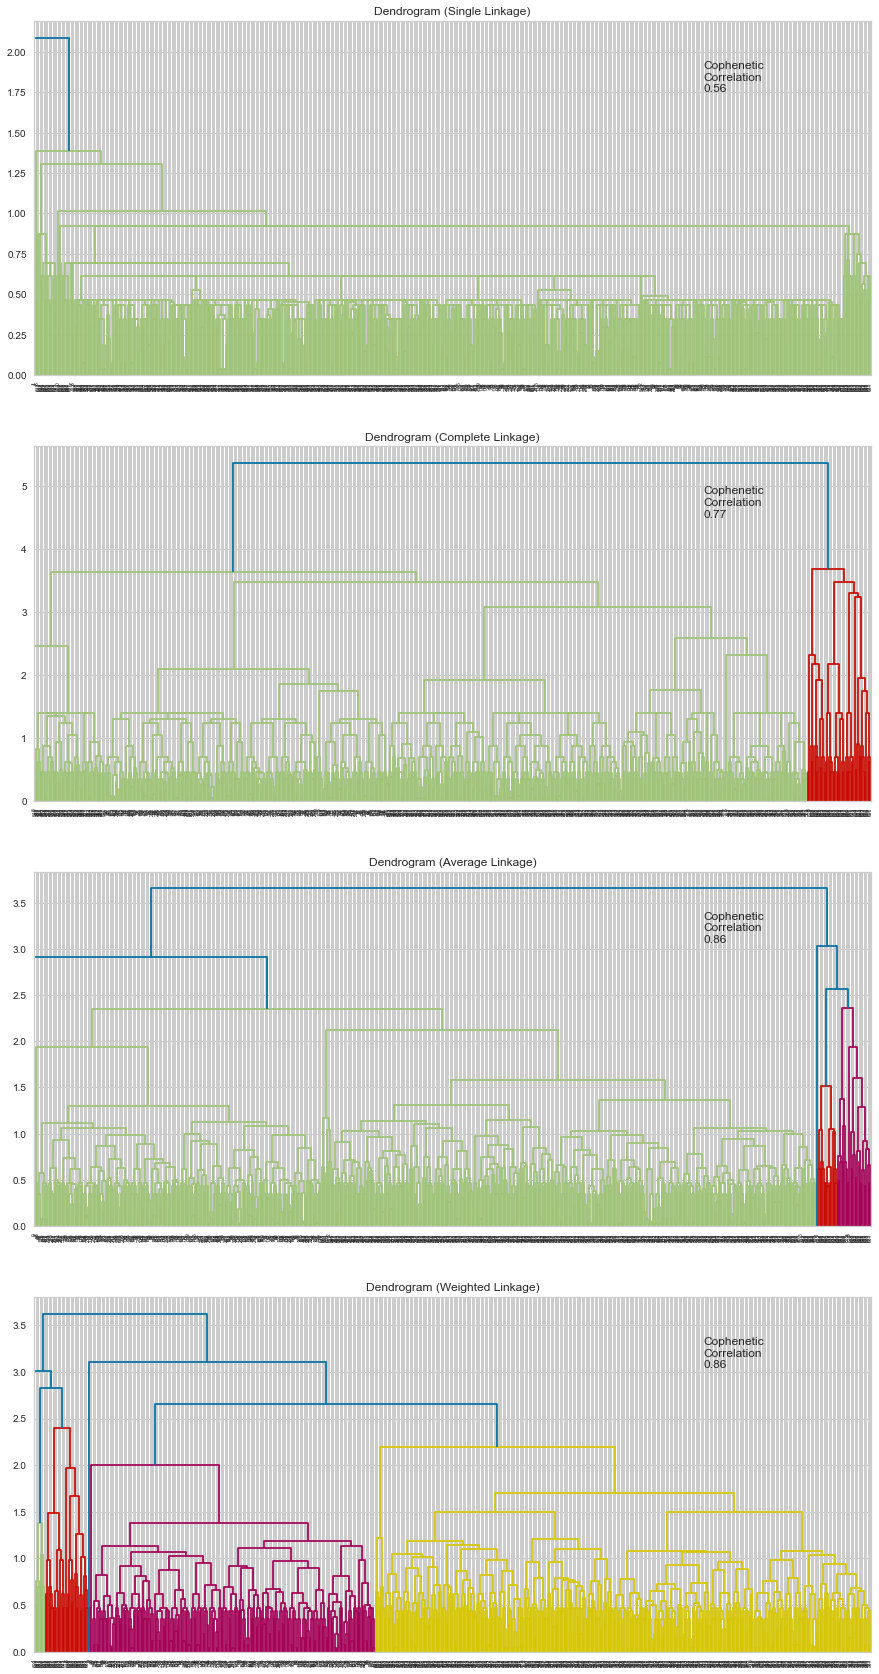

In [52]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_subset_scaled, metric="chebyshev", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_subset_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

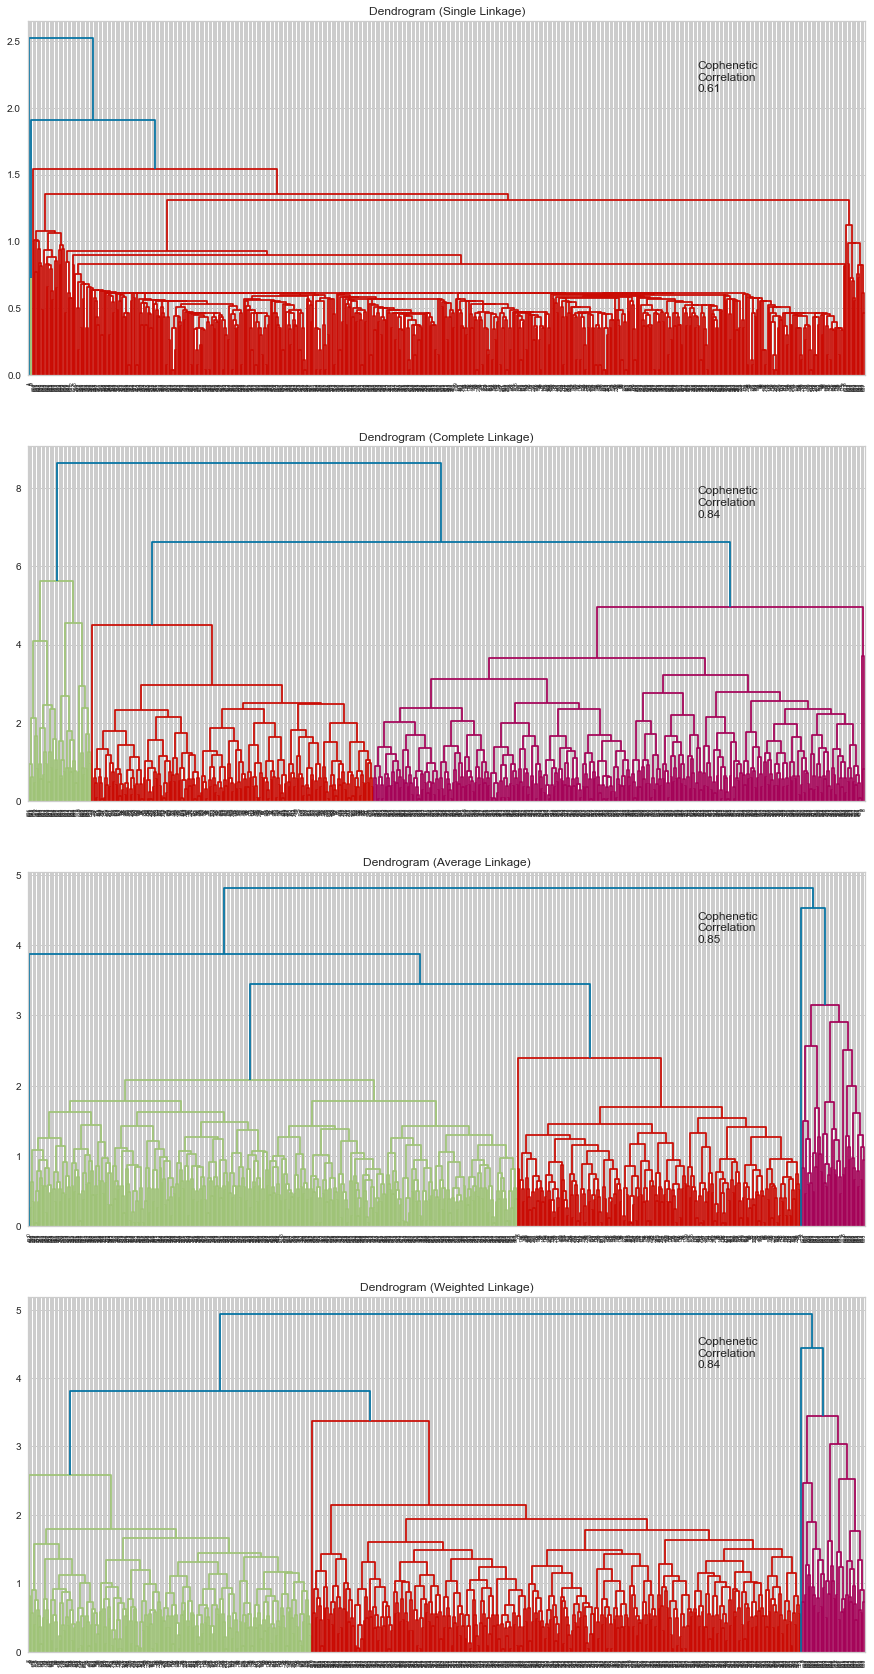

In [53]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_subset_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_subset_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

### Figure out appropriate number of clusters

##### The highest cophenetic correlation of 0.86 for the Chebychev distance method with weighted linkage, the Appropriate number of clusters appears to be 4 based on heights of clusters; however, the score is not much higher that Euclidean method with average linkage, a cophenetic score of 0.85, and  which appears to have 3 (really 4, with one very small) distinct clusters. 

##### I will choose the Euclidean method with average linkage for ease of comparison with K-means clustering. 


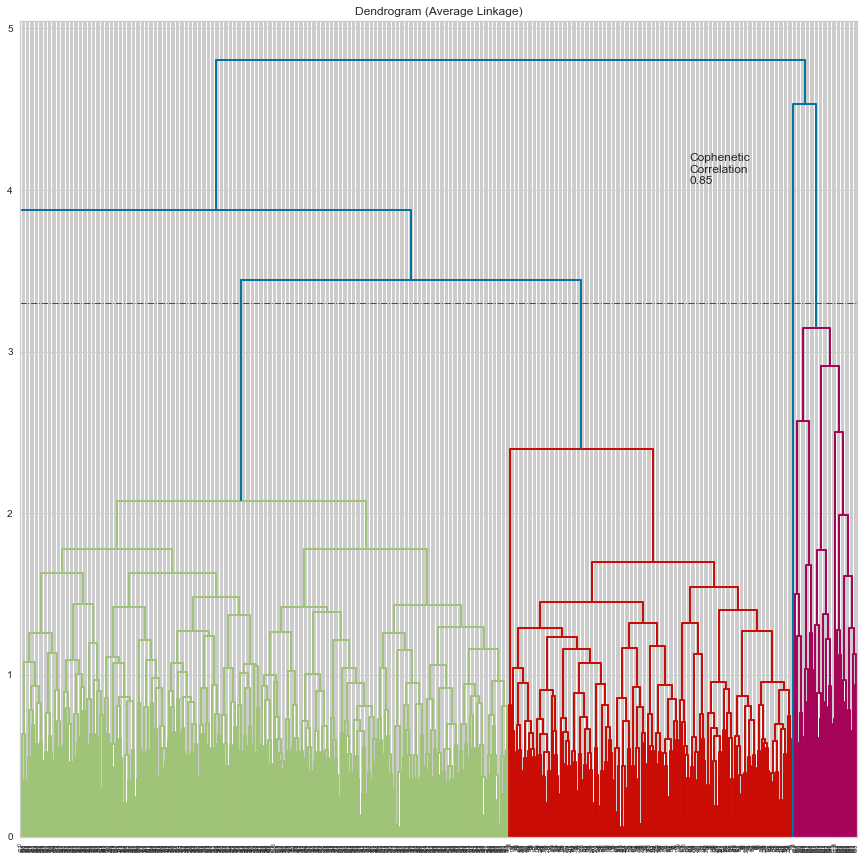

In [54]:
# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_subset_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_subset_scaled))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.3)
plt.axhline(y=3.3, c="red", lw=1, linestyle="dashdot")

### Cluster Profile

In [55]:
HCmodel_3 = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel_3.fit(data_subset_scaled)


AgglomerativeClustering(linkage='average', n_clusters=3)

In [56]:
HCmodel_4 = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel_4.fit(data_subset_scaled)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [57]:
data["HC_Clusters_3"] = HCmodel_3.labels_
data["HC_Clusters_4"] = HCmodel_4.labels_

In [78]:
cluster_profile_HC3 = data.groupby("HC_Clusters_3").median()


In [79]:
cluster_profile_HC3["count_in_each_segment"] = (
    data.groupby("HC_Clusters_3")["Total_calls_made"].count().values
)

In [80]:
cluster_profile_HC3.style.highlight_max(color="lightgreen", axis=0)
# additional columns added to data were not added to "data_subset_scaled" and therefore did not impact the model build. These columns (K means segment and HC_Cluster_4) should be igmored

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters_4,count_in_each_segment
HC_Clusters_3,,,,,,,,
0,17000.000000,4.000000,2.000000,2.000000,3.000000,1.000000,0.000000,597
1,84000.000000,9.000000,1.000000,8.000000,1.000000,0.000000,1.000000,49
2,50000.000000,3.000000,0.000000,10.000000,9.000000,2.000000,2.000000,1


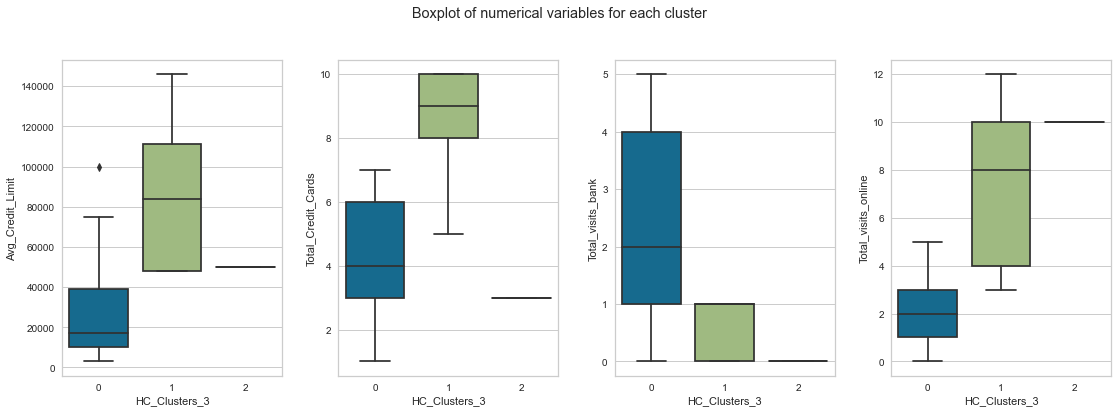

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=data[num_col[counter]], x=data["HC_Clusters_3"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [81]:
cluster_profile_HC4 = data.groupby("HC_Clusters_4").median()


In [82]:
cluster_profile_HC4["count_in_each_segment"] = (
    data.groupby("HC_Clusters_4")["Total_calls_made"].count().values
)
cluster_profile_HC4.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters_3,count_in_each_segment
HC_Clusters_4,,,,,,,,
0,17000.000000,4.000000,2.000000,2.000000,3.000000,1.000000,0.000000,596
1,84000.000000,9.000000,1.000000,8.000000,1.000000,0.000000,1.000000,49
2,50000.000000,3.000000,0.000000,10.000000,9.000000,2.000000,2.000000,1
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1


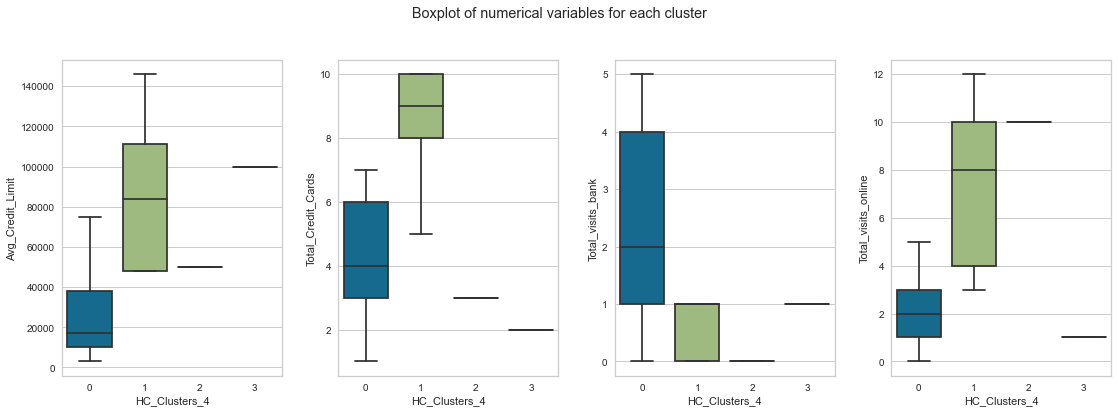

In [64]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=data[num_col[counter]], x=data["HC_Clusters_4"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## K-means vs Hierarchical Clustering
Compare clusters obtained from K-means and Hierarchical clustering techniques

In [83]:
# Cluster Profile for K-means clustering
data_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters_3,HC_Clusters_4,count_in_each_segment
K_means_segments,,,,,,,,
0,91000.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,47
1,32000.000000,6.000000,3.000000,1.000000,2.000000,0.000000,0.000000,379
2,12000.000000,2.000000,1.000000,4.000000,7.000000,0.000000,0.000000,221


In [84]:
#cluster profile for hierarchical clustering
cluster_profile_HC3.style.highlight_max(color="lightgreen", axis=0)


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters_4,count_in_each_segment
HC_Clusters_3,,,,,,,,
0,17000.000000,4.000000,2.000000,2.000000,3.000000,1.000000,0.000000,597
1,84000.000000,9.000000,1.000000,8.000000,1.000000,0.000000,1.000000,49
2,50000.000000,3.000000,0.000000,10.000000,9.000000,2.000000,2.000000,1


#### Comparison
K-means clustering with 3 clusters appears to create 3 distinct clusters with clear differences in means for the following informative variables: Average credit limit, total credit cards, and total visits online
Hierarchical clustering, while producing 3 clusters, only produced 2 distinct clusters (cluster 2 contains only one member and iss therefore not useful given the context).

K-means clustering produces the best results and will be used for actionalble insights and recommendaations

## Actionable Insights and Recommendations
Conclude with the key takeaways for the business - What would be your recommendations to the business?

Questions to be answered: 
How can we improve market penetration?
How should we personalize our marketing campaigns to new customers? to existing customers?
What steps should we take to upgrade the service delivery models, to "ensure that customer queries are resolved faster?'

### Insights
Cluster 0: 47 members
- Median: Average Credit limit approx 91000;
- Median: Total Credit cards: 9
- Median: Total vistis bank: 1
- Median: Total vistis online:8 
- Median: total calls made: 1

Cluster 1: 379 members
- Median: Average Credit limit approx 32000;
- Median: Total Credit cards: 6
- Median: Total vistis bank: 3
- Median: Total vistis online:1
- Median: total calls made: 2

Cluster 2: 221 members
- Median: Average Credit limit approx 12000;
- Median: Total Credit cards: 2
- Median: Total vistis bank: 1
- Median: Total vistis online:4 
- Median: total calls made: 9

### Recommendations
Cluster 0 represents the small number of customers with multiple credit cards and higher average credit limits. these customers appear to monitor their credit online and require very little support

Cluster 1 represent customers with fewer credit cards than those customers in cluster 0; these customers vist the bank more than onlineand also need little support

Cluster 2 customers have the fewest number of credit cards and the lowest average credit limit; these customers require more support and do not visit the bank often

Recommendations:
- Build more models using a variety of hierarchical techniques to seek to improve the hierarchical clustering model
- Build models using data set with outliers replaced (current models are using data set with outliers not replaced)
- How can we improve market penetration?
    - Customers in cluster 2 might be new customers who have limited credit options and limited experience with banking; educate these customers on the advantages of online banking and icreasing credit limits in order to move these customers into cluster 1, the cluster with the highest number of customers and minimal support needs
- How should we personalize our marketing campaigns to new customers? to existing customers?
    - New Customers: Cluster 2 customers are likely new custoerms and appear to prefer usisng online banking. To target  new custoemrs, provide optimal online services and increase the number of knowledgeable support personnel to advise with their banking needs
    - Existing customers: Seek to move custoemrs from one cluster to another (cluster 2 to 1 to 0) by selling more credit services and increasing support options for these customers
What steps should we take to upgrade the service delivery models, to "ensure that customer queries are resolved faster?'
    - Customers with lower average credit limits and total credit cards are more likely to require support; they also visit online more than in person; to deliver better service, ensure that support personnel are easily accessible online and are trained to advise customers on increasing their credit cards and credit limits; Provide more onine support options to clients, such as chatbots and FAQs and online documentation